# <div class="usecase-title">Private Event Planning</div>

<div class="usecase-authors"><b>Authored by: </b>Harley Ngo</div>

<div class="usecase-date"><b>Date: </b> May 2024</div>

<div class="usecase-duration"><b>Duration:</b> 60 mins</div>

<div class="usecase-level-skill">
    <div class="usecase-level"><b> Level: </b>Intermediate</div>
    <div class="usecase-skill"><b> Pre-requisite Skills: </b>Python, NLP, Data Crawling</div>
</div>

<div class="usecase-subsection-blurb">
  <i>Dataset 1:</i> Venues for event bookings
  <br>
  <a href="https://data.melbourne.vic.gov.au/explore/dataset/venues-for-event-bookings/information/" target="_blank">Dataset Link</a>
</div>
<br>

<div class="usecase-subsection-blurb">
  <i>Dataset 2:</i> Bar, tavern, pub patron capacity
  <br>
  <a href="https://data.melbourne.vic.gov.au/explore/dataset/bars-and-pubs-with-patron-capacity/information/" target="_blank">Dataset Link</a>
  <br>
  <a href="https://data.melbourne.vic.gov.au/api/datasets/1.0/bars-and-pubs-with-patron-capacity/attachments/clue_definitions_pdf/">Metadata Link</a>
</div>
<br>

<div class="usecase-subsection-blurb">
  <i>Dataset 3:</i> Public barbecues
  <br>
  <a href="https://data.melbourne.vic.gov.au/explore/dataset/public-barbecues/information/" target="_blank">Dataset Link</a>
</div>
<br>

<div class="usecase-subsection-blurb">
  <i>Dataset 4:</i> Live Music Venues
  <br>
  <a href="https://data.melbourne.vic.gov.au/explore/dataset/live-music-venues/information/" target="_blank">Dataset Link</a>
</div>

# <div class="usecase-section-header"><h4>Project Objective, Overview & Research</h4></div>

<div class="usecase-subtitle">
<i><b>User Story</b></i>
</div>

<div class="usecase-subsection-blurb"><i>"As a individual or organization hosting a private event (e.g., wedding, birthday party, corporate retreat),
I want to plan and organize the event efficiently and effectively,
So that I can ensure it meets my specific requirements and creates a memorable experience for myself and my guests."</i></div>
<br>

<div class="usecase-subtitle">
<i><b>Objective</b></i>

<div class="usecase-subsection-blurb">'Private Event Planning' project contained two components, created over a 2 week investigation period. The objective is to create a comprehensive search that facilitates the planning and organization of private events, such as weddings, birthday parties, corporate retreats, and other special occasions.</div>
<br>

<div class="usecase-subsection-blurb"><b>Part 1</b> includes set up, fetching or loading datasets, pre-processing, data cleaning, saving datasets, and merging datasets.</div>

<br>

<div class="usecase-subsection-blurb"><b>Part 2</b> contains developing NLP model to extract users' needs and a crawling tool to get images of suggested location. </div>

# Part 1 (Set up & Pre-processing)
*   Set Up
*   Pre-processing
*   Merge Datasets

## Part 1.1: Set Up
*   Import Core Libraries
*   Import Dependencies

In [1]:
# Library
import pandas as pd
import requests

from tqdm.auto import tqdm
from io import StringIO

import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

import spacy

import requests
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO

from selenium import webdriver
import urllib.parse
from selenium.webdriver.common.by import By
import time

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Download datasets
def download_dataset(api_key, dataset_id, base_url='https://data.melbourne.vic.gov.au/api/explore/v2.1/catalog/datasets/'):
    format = 'csv'
    url = f'{base_url}{dataset_id}/exports/{format}'
    params = {
        'select': '*',
        'limit': -1,  # all records
        'lang': 'en',
        'timezone': 'UTC',
        'api_key': ''
    }

    with requests.get(url, params=params, stream=True) as response:
        if response.status_code == 200:
            total_size = int(response.headers.get('content-length', 0))
            chunk_size = 1024  # 1KB per chunk
            progress_bar = tqdm(total=total_size, unit='iB', unit_scale=True, desc=f"Downloading {dataset_id}")

            content = bytearray()
            for chunk in response.iter_content(chunk_size=chunk_size):
                if chunk:  # filter out keep-alive new chunks
                    content.extend(chunk)
                    progress_bar.update(len(chunk))

            progress_bar.close()
            data = pd.read_csv(StringIO(content.decode('utf-8')), delimiter=';')
            return data
        else:
            print(f'Request failed with status code {response.status_code}')
            return None

# Dataset IDs
dataset_ids = [
    'venues-for-event-bookings',
    'event-permits-2014-2018-including-film-shoots-photo-shoots-weddings-christmas-pa',
    'public-barbecues',
    'bars-and-pubs-with-patron-capacity',
    'live-music-venues'
]

# Initialize dictionary to hold the datasets
datasets = {}

# Download each dataset with a progress bar
for dataset_id in dataset_ids:
    datasets[dataset_id] = download_dataset(' ', dataset_id)
    if datasets[dataset_id] is not None:
        print(f"{dataset_id} downloaded successfully.")

venues-for-event-bookings downloaded successfully.


event-permits-2014-2018-including-film-shoots-photo-shoots-weddings-christmas-pa downloaded successfully.


public-barbecues downloaded successfully.


bars-and-pubs-with-patron-capacity downloaded successfully.


live-music-venues downloaded successfully.


## Part 1.2: Pre-processing

### Dataset 1: Venues for event bookings

In [3]:
events_venues = datasets['venues-for-event-bookings']
events_venues.head()

,geo_point_2d,geo_shape,prop_id,no_smoking,level_1_na,addresspt1,event,full_name,addressp_1,training,...,venue_recn,addresspt,sport,promotion,bookable,level_3_na,wedding,roadseg_id,sustainabi,level_2_na
0,"-37.819126879284596, 144.94274377653426","{""coordinates"": [144.94274377653426, -37.81912...",604120,N,Docklands,19.964707,Y,Docklands: All Other Spaces: Victoria Harbou...,334,N,...,1312,612595,NaN,NaN,Y,Victoria Harbour Promenade West,N,23300,NaN,All Other Spaces
1,"-37.81235139096792, 144.9810169487427","{""coordinates"": [144.9810169487427, -37.812351...",103807,N,Fitzroy Gardens,90.645899,Y,Fitzroy Gardens: FT - Lawn 10/Stage Lawn,286,N,...,115,111456,NaN,NaN,Y,NaN,N,0,M,FT - Lawn 10/Stage Lawn
2,"-37.82253142158812, 144.94594900298196","{""coordinates"": [144.94594900298196, -37.82253...",624154,N,Docklands,88.437160,Y,Docklands: All Other Spaces: Australia Wharf,4,N,...,1416,633207,NaN,NaN,Y,Australia Wharf,N,23302,NaN,All Other Spaces
3,"-37.822753634054926, 144.9728253732698","{""coordinates"": [144.9728253732698, -37.822753...",108615,N,Kings Domain,0.000000,Y,Kings Domain: KD - Lawn 1,0,Y,...,175,0,NaN,NaN,Y,NaN,N,0,M,KD - Lawn 1
4,"-37.821748399482225, 144.9703669487038","{""coordinates"": [144.9703669487038, -37.821748...",111022,N,Queen Victoria Gardens,64.322890,Y,Queen Victoria Gardens: QV - Lawn 2,347,N,...,223,111022,NaN,NaN,Y,NaN,Y,0,L,QV - Lawn 2


#### Add new column "event_type"

In [4]:
# if venues can host wedding -> 'event_type' = 'wedding'
events_venues.loc[events_venues['wedding'] == "Y", 'event_type'] = 'wedding'
events_venues.loc[events_venues['wedding'] != "Y", 'event_type'] = 'venue'

#### Create new column "description"

In [5]:
events_venues['description'] = events_venues.apply(lambda row: f"{row['full_name']}, {row['event_type']}", axis=1)

In [6]:
events_venues = events_venues[['geo_point_2d', 'description', 'venue_recn']]

### Dataset 2: Public barbecues

In [7]:
bbq = datasets['public-barbecues']
bbq.head()

,description,co_ordinates
0,Barbeque - Urban Design Single Hotplate,"-37.819821342236914, 144.97480170753713"
1,Barbeque - Fawkner Park Toddler Play Space,"-37.839163364409444, 144.98066702168143"
2,Barbeque - Urban Design Single Hotplate,"-37.78998719902451, 144.94502340388996"
3,Barbeque - Urban Design Single Hotplate,"-37.786978549708806, 144.95295755838"
4,Barbeque - Urban Design Double Hotplate - Waru...,"-37.79622323577933, 144.9266473544793"


#### Add new column "event_type"

In [8]:
bbq['event_type'] = 'bbq'

#### Create new column "description"

In [9]:
bbq['description'] = bbq.apply(lambda row: f"{row['description']}, {row['event_type']}", axis=1)

#### Rename columns

In [10]:
bbq.rename(columns={"co_ordinates": "geo_point_2d"}, inplace=True)

In [11]:
bbq.drop(columns=['event_type'], inplace=True)
bbq.head()

,description,geo_point_2d
0,"Barbeque - Urban Design Single Hotplate, bbq","-37.819821342236914, 144.97480170753713"
1,"Barbeque - Fawkner Park Toddler Play Space, bbq","-37.839163364409444, 144.98066702168143"
2,"Barbeque - Urban Design Single Hotplate, bbq","-37.78998719902451, 144.94502340388996"
3,"Barbeque - Urban Design Single Hotplate, bbq","-37.786978549708806, 144.95295755838"
4,Barbeque - Urban Design Double Hotplate - Waru...,"-37.79622323577933, 144.9266473544793"


### Dataset 3: Bars and pubs with patron capacity

In [12]:
bars = datasets['bars-and-pubs-with-patron-capacity']
bars.head()

,census_year,block_id,property_id,base_property_id,building_address,clue_small_area,trading_name,business_address,number_of_patrons,longitude,latitude,location
0,2002,11,108972,108972,10-22 Spencer Street MELBOURNE 3000,Melbourne (CBD),Explorers Inn,10-22 Spencer Street MELBOURNE 3000,50,144.955254,-37.820511,"-37.82051068881513, 144.95525416628004"
1,2002,14,103172,103172,31-39 Elizabeth Street MELBOURNE 3000,Melbourne (CBD),Connells Tavern,35 Elizabeth Street MELBOURNE 3000,350,144.964322,-37.817426,"-37.81742610667125, 144.964321660097"
2,2002,15,103944,103944,277-279 Flinders Lane MELBOURNE 3000,Melbourne (CBD),De Biers,"Unit 1, Basement , 277 Flinders Lane MELBOURNE...",400,144.965307,-37.817242,"-37.81724194023457, 144.96530699086"
3,2002,16,103938,103938,187 Flinders Lane MELBOURNE 3000,Melbourne (CBD),Adelphi Hotel,187 Flinders Lane MELBOURNE 3000,80,144.968385,-37.816360,"-37.81635974400108, 144.9683846004515"
4,2002,17,103925,103925,121-123 Flinders Lane MELBOURNE 3000,Melbourne (CBD),Velour,"Unit 1, Gnd & Bmt , 121 Flinders Lane MELBOURN...",350,144.970523,-37.815674,"-37.815673646380745, 144.97052296371248"


#### Add new column "event_type"

In [13]:
bars['event_type'] = 'bar and pub'

#### Create new column "description"

In [14]:
bars['description'] = bars.apply(lambda row: f"{row['trading_name']}, {row['business_address']}, {row['event_type']}", axis=1)

#### Rename columns

In [15]:
bars.rename(columns={"location": "geo_point_2d"}, inplace=True)

In [16]:
bars = bars[['description', 'number_of_patrons', 'geo_point_2d']]

### Dataset 4: Live music venues

In [17]:
music_events = datasets['live-music-venues']
music_events.head()

,property_number,venue_name,venue_address,space_type,website,lat,lon,location,geolocation
0,609454,Alumbra,"Shed 9, Victoria Harbour, Docklands, 3008",Nightclub,http://www.alumbra.com.au/,-37.816569,144.943835,POINT (144.943834998348 -37.816568815),"-37.81656881500009, 144.94383499834845"
1,506429,Sofitel Melbourne On Collins,"Sofitel Hotel, Collins Tower, 25 Collins Stree...",Accommodation,http://www.sofitel-melbourne.com.au/,-37.813765,144.972923,POINT (144.972923487598 -37.813765267006),"-37.81376526700552, 144.9729234875978"
2,646930,Bar Nacional,"Tenancy 47, Ground, 727 Collins Street, Dockla...",Bar,http://www.barnacional.com.au/,-37.820467,144.949823,POINT (144.949822902931 -37.820467259122),"-37.82046725912159, 144.94982290293075"
3,681513,Bomba Tapas Bar and Rooftop,"Ground & Rooftop, 103 Lonsdale Street, Melbour...",Bar,https://bombabar.com.au/,-37.810381,144.969236,POINT (144.969235763373 -37.810380634625),"-37.81038063462455, 144.9692357633733"
4,565482,Melbourne Museum,"11 Nicholson Street, Carlton, 3053",Museum,https://museumsvictoria.com.au/melbournemuseum/,-37.803728,144.973731,POINT (144.973731480634 -37.803728470513),"-37.80372847051283, 144.97373148063383"


#### Add new column "event_type"

In [18]:
music_events['event_type'] = 'live music'

#### Create new column "description"

In [19]:
music_events['description'] = music_events.apply(lambda row: f"{row['venue_name']}, {row['venue_address']}, {row['space_type']}, {row['event_type']}", axis=1)

#### Rename columns

In [20]:
music_events.rename(columns={'geolocation': 'geo_point_2d'}, inplace=True)

In [21]:
music_events = music_events[['description', 'geo_point_2d']]

## Part 1.3: Merge datasets

In [22]:
merged = pd.concat([bbq, music_events, bars, events_venues])
merged.head()

,description,geo_point_2d,number_of_patrons,venue_recn
0,"Barbeque - Urban Design Single Hotplate, bbq","-37.819821342236914, 144.97480170753713",NaN,NaN
1,"Barbeque - Fawkner Park Toddler Play Space, bbq","-37.839163364409444, 144.98066702168143",NaN,NaN
2,"Barbeque - Urban Design Single Hotplate, bbq","-37.78998719902451, 144.94502340388996",NaN,NaN
3,"Barbeque - Urban Design Single Hotplate, bbq","-37.786978549708806, 144.95295755838",NaN,NaN
4,Barbeque - Urban Design Double Hotplate - Waru...,"-37.79622323577933, 144.9266473544793",NaN,NaN


# Part 2: NLP Model

In [23]:
# search = input("What event do you want to host?: ")
search = "i want to a wedding in museum."

nlp = spacy.load("en_core_web_sm")
doc = nlp(search)

# Extract tokens based on their dependency relation or POS tag
desired_tokens = []
for token in doc:
    if token.dep_ == "dobj" or token.pos_ == "NOUN":
        desired_tokens.append(token.text)

What event do you want to host?:  i want to a wedding in museum.


Location: Melbourne Museum, 11 Nicholson Street, Carlton, 3053, Museum, live music
Geo Point: -37.80372847051283, 144.97373148063383


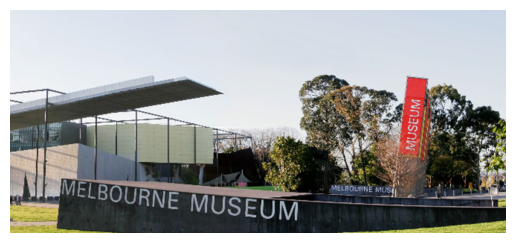

Location: Immigration Museum, 400-424 Flinders Street, Melbourne, 3000, Museum, live music
Geo Point: -37.81931971370013, 144.96049295002675


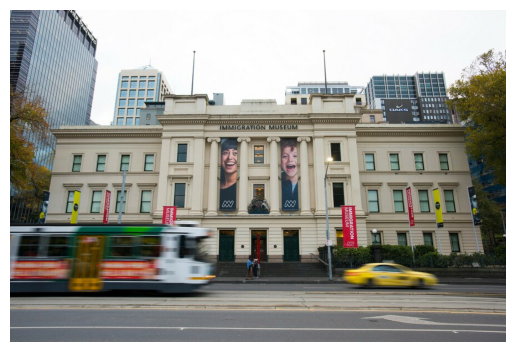

In [24]:
locations = merged['description'].tolist()
geo_points = merged['geo_point_2d'].tolist()
ratings = merged['venue_recn'].tolist()

def get_location_scores(locations, keywords):
    corpus = locations + keywords
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(corpus)

    similarity_scores = cosine_similarity(X[:-len(keywords)], X[-len(keywords):])

    aggregated_scores = np.mean(similarity_scores, axis=1)

    # Handle NaN ratings by assigning a default value
    default_rating = 0  # You can change this to any default value you prefer
    ratings_with_default = [rating if not np.isnan(rating) else default_rating for rating in ratings]

    location_scores = list(zip(locations, aggregated_scores, geo_points, ratings_with_default))

    sorted_location_scores = sorted(location_scores, key=lambda x: (x[1], x[3]), reverse=True)

    return sorted_location_scores

keywords = desired_tokens
location_scores = get_location_scores(locations, keywords)

# Get the top two scores
top_scores = sorted(set(score for _, score, _, _ in location_scores), reverse=True)[:2]

selected_locations = []

for location, score, geo_point, rating in location_scores:
    if score in top_scores:
        selected_locations.append((location, geo_point))

# print("The selected Locations:")
# print(f"Location: {selected_locations[0][0]}")
# print(f"Geo Point: {selected_locations[0][1]}")

def get_image_urls(query):
    # Format the query for the Google Images search URL
    query = urllib.parse.quote_plus(query)
    url = f"https://www.google.com/search?tbm=isch&q={query}&sca_esv=d265e0c6ccb16526&sca_upv=1&sxsrf=ADLYWIIJluO8Tl6B8gYYjUNsIRE7IqBMRg:1715047206989&source=hp&biw=1504&bih=834&ei=Jos5ZsmSOtee4-EP0sC_-AM&iflsig=AL9hbdgAAAAAZjmZNrtKZCOmD-qgr09kzXmB9jNPqMTQ&ved=0ahUKEwjJvazcuPqFAxVXzzgGHVLgDz8Q4dUDCA8&uact=5&oq=events&gs_lp=EgNpbWciBmV2ZW50czIFEAAYgAQyBRAAGIAEMgUQABiABDIFEAAYgAQyBRAAGIAEMgUQABiABDIFEAAYgAQyBRAAGIAEMgUQABiABDIFEAAYgARI_ApQqQNYuwhwAXgAkAEAmAGiAaABlAeqAQMwLja4AQPIAQD4AQGKAgtnd3Mtd2l6LWltZ5gCB6AC4QeoAgrCAgcQIxgnGOoCwgIEECMYJ8ICCBAAGIAEGLEDwgILEAAYgAQYsQMYgwGYAxySBwMxLjagB-Ui&sclient=img&udm=2"

    return url

def extract_image_urls(query):
    driver = webdriver.Chrome() #need chromedriver to be in same folder
    driver.get(get_image_urls(query))
    driver.find_element(By.XPATH, '//*[@id="islrg"]/div[1]/div[1]').click()
    time.sleep(4)
    
    # Execute JavaScript to extract the src attribute
    script = """
    var elements = document.querySelectorAll('#Sva75c div div div div div div a img');
    var srcList = [];
    elements.forEach(function(element) {
        srcList.push(element.src);
    });
    return srcList;
    """
    src_list = driver.execute_script(script)
    
    driver.quit()
    
    return src_list

for i in range(len(selected_locations)):
    print(f"Location: {selected_locations[i][0]}")
    print(f"Geo Point: {selected_locations[i][1]}")

    # Example usage:
    image_urls = extract_image_urls(selected_locations[i][0])

    # Define a variable to store the image URL
    img_url = None

    # Try to access the first image URL
    try:
        response = requests.get(image_urls[0], verify=False)
        response.raise_for_status()  # Check if the request was successful
        img_url = image_urls[1]  # Store the URL if successful
    except (requests.RequestException, IndexError):
        # If the request failed or there are no image URLs
        print("Failed to retrieve the first image URL. Trying the second one...")
        
        # Try to access the second image URL
        try:
            response = requests.get(image_urls[0], verify=False)
            response.raise_for_status()  # Check if the request was successful
            img_url = image_urls[0]  # Store the URL if successful
        except (requests.RequestException, IndexError):
            print("Failed to retrieve the second image URL.")

    if img_url:
        # Download the image
        response = requests.get(img_url, verify=False)

        # Open the image with PIL
        image = Image.open(BytesIO(response.content))

        # Display the image using Matplotlib
        plt.imshow(image)
        plt.axis('off')  # Turn off axis
        plt.show()
    else:
        print("No image URL available.")